# Surface Corrections


In [6]:
from PeriFlakes import *
from SimDataDB import *
from matplotlib import pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

In [7]:
H = 2.0 ; T = 1.0 ; E = 1.0 ; nu = 0.0;
solutions = {'uniaxial': (1, T*H*(2.0*nu**2+nu-1.0)/(E*(nu-1))),
             'isotropic':(1, T*H*(1.0-nu-2.0*nu**2)/E),
             'shear':    (0, 2.0*T*H*(1.0+nu)/E) }

In [8]:
L=1.0
N=20
delta= 1.5*2.0*L/float(N)
PB = PeriBlock(L,N,delta,ficticious=True,E=E,nu=nu)
PB.setbcs([(PB.right,0),(PB.left,0),(PB.bottom,1)], [(PB.ftop,[0,1])])

The matrix is formed by assembling an interior graph and an exterior graph for the ficticious domains. We see that they have the same structure if we are using the "trivial" ficticious domain.

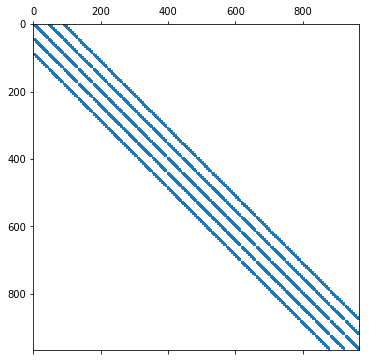

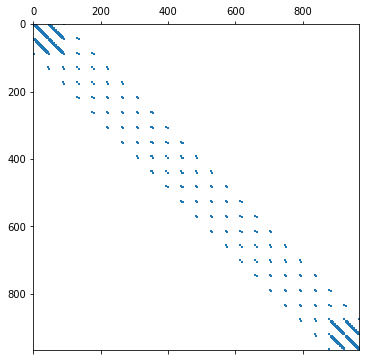

In [9]:
K,R = PB._assemble_KR("Fbased","cubic")
plt.spy(K,marker=',')
plt.show()
Kf,Rf = PB._assemble_KR_fict("trivial","Fbased","cubic")
plt.spy(Kf,marker=',')
plt.show()


The other boundary condition stencil is a little different. We can see that it contributes very differently to the matrix:

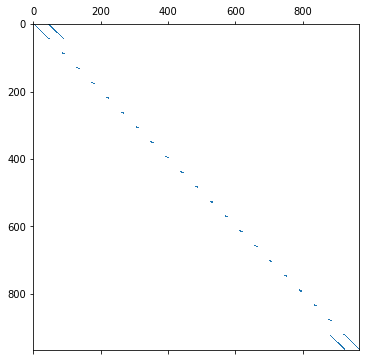

In [15]:
Kf,Rf = PB._assemble_KR_fict("bobaru","Fbased","cubic")
plt.spy(Kf,marker=',')
plt.show()

I had to do some direct investigation of the matrix to make sure al lthe ducks were in a row:

In [13]:
#for e in PB.HFictStencil4:
#    print
#    for l in PB.dm_PtVec.Get_List(e):
#         for m in PB.dm_PtVec.Get_List(e):
#             print Kf[l,m],
#         print 

In [14]:
# for e in PB.HFictStencil3:
#     print
#     print Rf[PB.dm_PtVec.Get_List(e)]
#     for l in PB.dm_PtVec.Get_List(e):
#         for m in PB.dm_PtVec.Get_List(e):
#             print Kf[l,m]/4.5,
#         print 

## Finite difference stencil

These types of surface correction effects are implemented in [ficticious_kernels_pop.py](PeriFlakes/ficticious_kernels_pop.py). 
The finite difference stencil can be generalized by defining a normal between two points,
\begin{equation}
\mathbf{n}^{ab} = \frac{\mathbf{x}^a-\mathbf{x}^b}{\left|\mathbf{x}^a-\mathbf{x}^b\right|},
\end{equation}
where $a$ and $b$ are index arguments.
Then, in the direction normal to the surface, $\mathbf{n}^n = \mathbf{n}^{fo}$ and $\epsilon^n=\epsilon^{fo}$.
In the tangential direction, the normal and strain are averaged by both directions to obtain a central finite difference,
$\mathbf{e}^t = \left( \mathbf{n}^{+o} + \mathbf{n}^{o-} \right) / 2$ and 
If the ficticious node is all the way at an end, only one of the winded directions is used. 
We build the deformation gradient from finite differences,
\begin{equation}
\mathbf{F}=\frac{\left(\mathbf{u}^{f}-\mathbf{u}^{o}\right)}{\left|\mathbf{x}^{f}-\mathbf{x}^{o}\right|}\otimes\mathbf{n}+\frac{\left(\mathbf{u}^{+}-\mathbf{u}^{-}\right)}{\left|\mathbf{x}^{+}-\mathbf{x}^{-}\right|}\otimes\mathbf{e}\_{t}
\end{equation}
and then apply the BC constraint by
\begin{equation}
 0=\lambda\mathrm{tr}\left[\varepsilon\right]\mathbf{n}+2G\varepsilon\mathbf{n}-\bar{\mathbf{t}}
\end{equation}
with $\varepsilon=\frac{1}{2}\left(\mathbf{F}^{T}+\mathbf{F}\right)$.

This is equivalent to the stencil in Le and Bobaru, but it rotates.


In [16]:
u = PB.solve("Silling","cubic",stab=2,fictmet='bobaru')
N = int(PB.NPart**0.5)
u = u.reshape(N,N,2)
x = PB.x.reshape(N,N,2)
#ax = plt.gca()
#ax.quiver(x[:,:,0],x[:,:,1],u[:,:,0],u[:,:,1],angles='uv',scale_units='xy',scale=10.0)
#ax.set_aspect('equal', 'datalim')

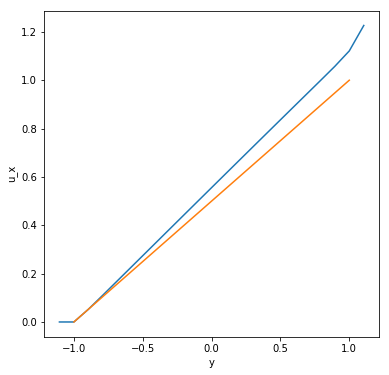

In [17]:
plt.plot(x[:,N/2,1],u[:,N/2,1])
plt.plot([-1,1],[0,0.5*solutions['uniaxial'][1]])
plt.xlabel('y'); plt.ylabel('u_x');

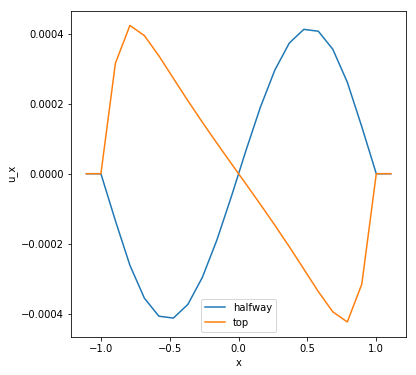

In [18]:
plt.plot(x[:,N/2,1],u[N/2,:,0],label='halfway');
plt.plot(x[:,N/2,1],u[-1,:,0],label='top');
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');